In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

from dataclasses import dataclass

from transformers import AutoTokenizer, AutoModelForCausalLM
import json, os
import matplotlib.pyplot as plt
import time
import math

## Benchmarking with vs without KV caching

1. Use [`meta-llama/Llama-3.1-8B`](https://huggingface.co/meta-llama/Llama-3.1-8B) and sweep `max_new_tokens`=`min_new_tokens`  by powers of two from 1 to 512, using the same short prompt ("Once upon a time,") for all output sequence lengths. Plot time vs output sequence length.
2. Now repeat the same with `use_cache=False` in `model.generate()` -- add this plot to the same figure. Make sure to include a legend and descriptive labels/titles. Describe the trends you see in 1-2 sentences -- play around with both log scales and linear scales for a clearer idea of the trends -- **you will only need to include one version in your report**, however.
3. Repeat 1-2 with a much longer prompt, read in from `long_prompt.txt`. **For this question, you only need to sweep from 1 to 32 without the KV cache -- with KV cache, you should be able to reach 512 without issues.** In ~2 sentences, (instead of just comparing KV cache vs no KV cache) compare the trends you see with those from your first plot, and provide an explanation for the trends you observe.
4. Repeat 1-2 with [`meta-llama/Llama-3.2-1B`](https://huggingface.co/meta-llama/Llama-3.2-1B). Again, in ~2 sentences, compare the trends you see with those from your first plot, and provide an explanation for the trends you observe.
5. Repeat 1-2 with [`meta-llama/Llama-2-7b`](https://huggingface.co/meta-llama/Llama-2-7b). Once again, write ~2 sentences to compare the trends you see with those from your first plot, and provide an explanation for the trends you observe.

In total, you will include four (4) figures, one (1) explanation of the general kv vs no kv trend, and reflections for three (3) pairwise comparisons in your report. You may need to restart your kernel each time you want to use a new model.

In [8]:
short_prompt = "Once upon a time,"

with open("long_prompt.txt") as f:
    long_prompt = f.read().strip()

### One generation example

The code below should run without modification in an environment that contains the necessary libraries. A TA used 1 L40S GPU to run these exact cells.

You can adapt it to complete the questions above. Again, **you may need to restart your kernel in between loading in different models**

In [3]:

tokenizer = AutoTokenizer.from_pretrained('meta-llama/Llama-3.1-8B')
model = AutoModelForCausalLM.from_pretrained('meta-llama/Llama-3.1-8B', dtype='bfloat16').to('cuda')

Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00, 121.29it/s]


In [9]:
prompt_toks = tokenizer(short_prompt, return_tensors="pt").to('cuda')
start = time.time()
torch.cuda.synchronize()
output = model.generate(**prompt_toks, max_new_tokens=256, use_cache=True) # true by default
torch.cuda.synchronize()
end = time.time()
print("Generation of", output.shape[1]-prompt_toks['input_ids'].shape[1], "new tokens with KV cache took", round(end-start), "seconds.")
print("-----")
print("Output:", tokenizer.batch_decode(output))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generation of 256 new tokens with KV cache took 6 seconds.
-----
Output: ['<|begin_of_text|>Once upon a time, there was a man who worked as a bus driver. One day, he was driving his bus when he saw a young boy running along the side of the road. The boy was trying to catch up to the bus, but he was having a hard time keeping up. The bus driver felt sorry for the boy and decided to stop the bus so that he could help him get on board.\nThe boy was very grateful and thanked the bus driver for his kindness. He told the bus driver that he was running late for school and that he had been trying to catch the bus for the past few minutes. The bus driver assured the boy that he would get him to school on time.\nThe boy sat down in the seat next to the bus driver and they began to chat. The boy told the bus driver that his name was John and that he was in the third grade. The bus driver told John that his name was Mr. Smith and that he was a bus driver.\nJohn asked Mr. Smith if he could ask him 

In [10]:
prompt_toks = tokenizer(short_prompt, return_tensors="pt").to('cuda')

start = time.time()
torch.cuda.synchronize()
output = model.generate(**prompt_toks, max_new_tokens=256, use_cache=False) # no KV cache
torch.cuda.synchronize()
end = time.time()
print("Generation of", output.shape[1]-prompt_toks['input_ids'].shape[1], "new tokens without KV cache took", round(end-start), "seconds.")
print("-----")
print("Output:", tokenizer.batch_decode(output))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generation of 256 new tokens without KV cache took 8 seconds.
-----
Output: ['<|begin_of_text|>Once upon a time, I had a very different life. I was a professional, living in a big city, with a high-powered job, a beautiful house, a fancy car and a lot of money. But I was miserable. I was always stressed out, and I felt like I was running on a hamster wheel, going nowhere. I was so unhappy that I decided to quit my job and move to a small town in the middle of nowhere. I wanted to start over, to find happiness and fulfillment in a new place. And that’s when I discovered the magic of small town life.\nSmall town life is something that many people dream of. It’s a place where everyone knows each other, where the pace of life is slower and more relaxed, and where people are more connected to the land and to each other. It’s a place where you can live a simpler, more authentic life, where you can focus on what’s important, and where you can find a sense of community and belonging.\nSmall to

### Example plotting code

In [ ]:
times_with_kv = []
times_no_kv = []

In [ ]:
# import matplotlib.pyplot as plt

# plt.plot(range(10), times_with_kv, label="with kv cache") # or use [2**x for x in range(10)] for linear scale
# plt.plot(range(10), times_no_kv, label="no kv cache")
# xticks = [f"2^{x}" for x in range(10)]
# plt.xticks(list(range(10)), labels=xticks)
# plt.legend()
# # TODO: titles, etc.
# plt.savefig("[YOUR FILEPATH HERE]", bbox_inches="tight")
# plt.show()

## Experiment 1: Llama-3.1-8B with Short Prompt

Sweep max_new_tokens from 1 to 512 (powers of 2) with and without KV cache.

In [4]:
# Experiment 1: Llama-3.1-8B with short prompt
# Model should already be loaded from above cells

token_counts = [2**i for i in range(10)]  # 1, 2, 4, 8, 16, 32, 64, 128, 256, 512
times_exp1_with_kv = []
times_exp1_no_kv = []

print("Running Experiment 1: Llama-3.1-8B with short prompt")
print("=" * 60)

# Benchmark with KV cache
print("\nWith KV cache:")
for n_tokens in token_counts:
    prompt_toks = tokenizer(short_prompt, return_tensors="pt").to('cuda')
    
    start = time.time()
    torch.cuda.synchronize()
    output = model.generate(**prompt_toks, max_new_tokens=n_tokens, min_new_tokens=n_tokens, use_cache=True)
    torch.cuda.synchronize()
    elapsed = time.time() - start
    
    times_exp1_with_kv.append(elapsed)
    print(f"  {n_tokens} tokens: {elapsed:.3f}s")

# Benchmark without KV cache
print("\nWithout KV cache:")
for n_tokens in token_counts:
    prompt_toks = tokenizer(short_prompt, return_tensors="pt").to('cuda')
    
    start = time.time()
    torch.cuda.synchronize()
    output = model.generate(**prompt_toks, max_new_tokens=n_tokens, min_new_tokens=n_tokens, use_cache=False)
    torch.cuda.synchronize()
    elapsed = time.time() - start
    
    times_exp1_no_kv.append(elapsed)
    print(f"  {n_tokens} tokens: {elapsed:.3f}s")

print("\nExperiment 1 complete!")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Running Experiment 1: Llama-3.1-8B with short prompt

With KV cache:


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  1 tokens: 0.473s
  2 tokens: 0.142s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  4 tokens: 0.150s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  8 tokens: 0.264s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  16 tokens: 0.953s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  32 tokens: 1.545s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  64 tokens: 3.159s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  128 tokens: 4.008s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  256 tokens: 11.643s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  512 tokens: 22.212s

Without KV cache:
  1 tokens: 0.043s
  2 tokens: 0.106s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  4 tokens: 0.198s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  8 tokens: 0.386s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  16 tokens: 0.783s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  32 tokens: 1.339s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  64 tokens: 3.258s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  128 tokens: 6.784s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  256 tokens: 16.708s
  512 tokens: 49.952s

Experiment 1 complete!


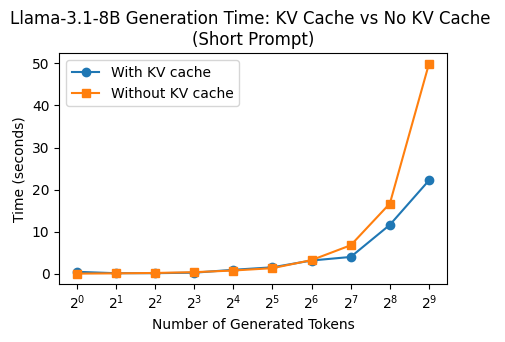

In [14]:
# Plot Experiment 1
plt.figure(figsize=(5, 3))
plt.plot(range(len(token_counts)), times_exp1_with_kv, marker='o', label="With KV cache")
plt.plot(range(len(token_counts)), times_exp1_no_kv, marker='s', label="Without KV cache")
xticks = [f"$2^{{{i}}}$" for i in range(len(token_counts))]
plt.xticks(list(range(len(token_counts))), labels=xticks)
plt.xlabel("Number of Generated Tokens")
plt.ylabel("Time (seconds)")
plt.title("Llama-3.1-8B Generation Time: KV Cache vs No KV Cache \n(Short Prompt)")
plt.legend()
plt.savefig("exp1_llama31_8b_short_prompt.pdf", bbox_inches="tight")
plt.show()

## Experiment 2: Llama-3.1-8B with Long Prompt

With KV cache: sweep 1 to 512. Without KV cache: sweep 1 to 32 (as instructed).

In [15]:
# Experiment 2: Llama-3.1-8B with long prompt
# Model should still be loaded

token_counts_with_kv = [2**i for i in range(10)]  # 1 to 512
token_counts_no_kv = [2**i for i in range(6)]     # 1 to 32
times_exp2_with_kv = []
times_exp2_no_kv = []

print("Running Experiment 2: Llama-3.1-8B with long prompt")
print("=" * 60)

# Benchmark with KV cache (1 to 512)
print("\nWith KV cache (1 to 512 tokens):")
for n_tokens in token_counts_with_kv:
    prompt_toks = tokenizer(long_prompt, return_tensors="pt").to('cuda')
    
    start = time.time()
    torch.cuda.synchronize()
    output = model.generate(**prompt_toks, max_new_tokens=n_tokens, min_new_tokens=n_tokens, use_cache=True)
    torch.cuda.synchronize()
    elapsed = time.time() - start
    
    times_exp2_with_kv.append(elapsed)
    print(f"  {n_tokens} tokens: {elapsed:.3f}s")

# Benchmark without KV cache (1 to 32 only)
print("\nWithout KV cache (1 to 32 tokens only):")
for n_tokens in token_counts_no_kv:
    prompt_toks = tokenizer(long_prompt, return_tensors="pt").to('cuda')
    
    start = time.time()
    torch.cuda.synchronize()
    output = model.generate(**prompt_toks, max_new_tokens=n_tokens, min_new_tokens=n_tokens, use_cache=False)
    torch.cuda.synchronize()
    elapsed = time.time() - start
    
    times_exp2_no_kv.append(elapsed)
    print(f"  {n_tokens} tokens: {elapsed:.3f}s")

print("\nExperiment 2 complete!")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Running Experiment 2: Llama-3.1-8B with long prompt

With KV cache (1 to 512 tokens):


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  1 tokens: 10.139s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  2 tokens: 10.159s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  4 tokens: 13.040s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  8 tokens: 10.095s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  16 tokens: 14.070s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  32 tokens: 13.759s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  64 tokens: 15.770s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  128 tokens: 21.184s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  256 tokens: 29.923s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  512 tokens: 48.425s

Without KV cache (1 to 32 tokens only):


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  1 tokens: 11.412s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  2 tokens: 23.584s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  4 tokens: 46.307s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  8 tokens: 90.127s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  16 tokens: 182.037s
  32 tokens: 335.845s

Experiment 2 complete!


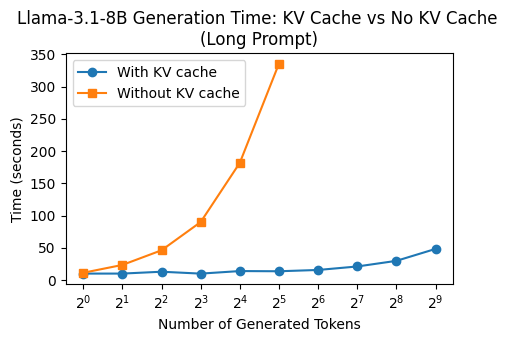

In [18]:
# Plot Experiment 2
plt.figure(figsize=(5, 3))
plt.plot(range(len(token_counts_with_kv)), times_exp2_with_kv, marker='o', label="With KV cache")
plt.plot(range(len(token_counts_no_kv)), times_exp2_no_kv, marker='s', label="Without KV cache")
xticks_labels = [f"$2^{{{i}}}$" for i in range(len(token_counts_with_kv))]
plt.xticks(list(range(len(token_counts_with_kv))), labels=xticks_labels)
plt.xlabel("Number of Generated Tokens")
plt.ylabel("Time (seconds)")
plt.title("Llama-3.1-8B Generation Time: KV Cache vs No KV Cache \n(Long Prompt)")
plt.legend()
plt.savefig("exp2_llama31_8b_long_prompt.pdf", bbox_inches="tight")
plt.show()

## Experiment 3: Llama-3.2-1B with Short Prompt

**Note: You may need to restart your kernel and load a new model for this experiment.**

Sweep max_new_tokens from 1 to 512 (powers of 2) with and without KV cache.

In [4]:
# Load Llama-3.2-1B model
# Uncomment these lines if you restarted the kernel:
tokenizer = AutoTokenizer.from_pretrained('meta-llama/Llama-3.2-1B')
model = AutoModelForCausalLM.from_pretrained('meta-llama/Llama-3.2-1B', dtype='bfloat16').to('cuda')


In [5]:
# Experiment 3: Llama-3.2-1B with short prompt
token_counts = [2**i for i in range(10)]  # 1 to 512
times_exp3_with_kv = []
times_exp3_no_kv = []

print("Running Experiment 3: Llama-3.2-1B with short prompt")
print("=" * 60)

# Benchmark with KV cache
print("\nWith KV cache:")
for n_tokens in token_counts:
    prompt_toks = tokenizer(short_prompt, return_tensors="pt").to('cuda')
    
    start = time.time()
    torch.cuda.synchronize()
    output = model.generate(**prompt_toks, max_new_tokens=n_tokens, min_new_tokens=n_tokens, use_cache=True)
    torch.cuda.synchronize()
    elapsed = time.time() - start
    
    times_exp3_with_kv.append(elapsed)
    print(f"  {n_tokens} tokens: {elapsed:.3f}s")

# Benchmark without KV cache
print("\nWithout KV cache:")
for n_tokens in token_counts:
    prompt_toks = tokenizer(short_prompt, return_tensors="pt").to('cuda')
    
    start = time.time()
    torch.cuda.synchronize()
    output = model.generate(**prompt_toks, max_new_tokens=n_tokens, min_new_tokens=n_tokens, use_cache=False)
    torch.cuda.synchronize()
    elapsed = time.time() - start
    
    times_exp3_no_kv.append(elapsed)
    print(f"  {n_tokens} tokens: {elapsed:.3f}s")

print("\nExperiment 3 complete!")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Running Experiment 3: Llama-3.2-1B with short prompt

With KV cache:


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  1 tokens: 0.436s
  2 tokens: 0.063s
  4 tokens: 0.063s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  8 tokens: 0.128s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  16 tokens: 0.233s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  32 tokens: 0.494s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  64 tokens: 0.971s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  128 tokens: 1.889s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  256 tokens: 3.219s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  512 tokens: 7.407s

Without KV cache:
  1 tokens: 0.018s
  2 tokens: 0.031s
  4 tokens: 0.062s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  8 tokens: 0.120s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  16 tokens: 0.234s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  32 tokens: 0.461s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  64 tokens: 0.948s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  128 tokens: 1.885s


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  256 tokens: 4.020s
  512 tokens: 9.936s

Experiment 3 complete!


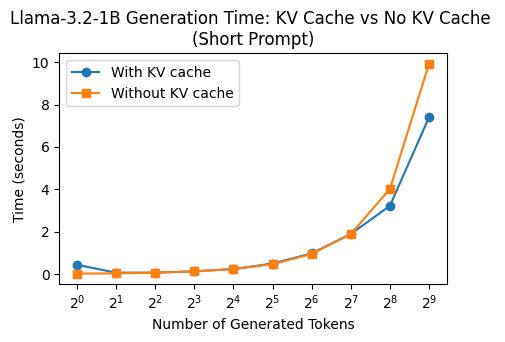

In [6]:
# Plot Experiment 3
plt.figure(figsize=(5, 3))
plt.plot(range(len(token_counts)), times_exp3_with_kv, marker='o', label="With KV cache")
plt.plot(range(len(token_counts)), times_exp3_no_kv, marker='s', label="Without KV cache")
xticks = [f"$2^{{{i}}}$" for i in range(len(token_counts))]
plt.xticks(list(range(len(token_counts))), labels=xticks)
plt.xlabel("Number of Generated Tokens")
plt.ylabel("Time (seconds)")
plt.title("Llama-3.2-1B Generation Time: KV Cache vs No KV Cache \n(Short Prompt)")
plt.legend()
plt.savefig("exp3_llama32_1b_short_prompt.pdf", bbox_inches="tight")
plt.show()

## Experiment 4: Llama-2-7b with Short Prompt

**Note: You may need to restart your kernel and load a new model for this experiment.**

Sweep max_new_tokens from 1 to 512 (powers of 2) with and without KV cache.

In [6]:
# Load Llama-2-7b-hf model
# Uncomment these lines if you restarted the kernel:
tokenizer = AutoTokenizer.from_pretrained('meta-llama/Llama-2-7b-hf', cache_dir='/usr1/data/mingqia2/')
model = AutoModelForCausalLM.from_pretrained('meta-llama/Llama-2-7b-hf', cache_dir='/usr1/data/mingqia2/', torch_dtype=torch.bfloat16).to('cuda')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
# Experiment 4: Llama-2-7b-hf with short prompt
token_counts = [2**i for i in range(10)]  # 1 to 512
times_exp4_with_kv = []
times_exp4_no_kv = []

print("Running Experiment 4: Llama-2-7b-hf with short prompt")
print("=" * 60)

# Benchmark with KV cache
print("\nWith KV cache:")
for n_tokens in token_counts:
    prompt_toks = tokenizer(short_prompt, return_tensors="pt").to('cuda')
    
    start = time.time()
    torch.cuda.synchronize()
    output = model.generate(**prompt_toks, max_new_tokens=n_tokens, min_new_tokens=n_tokens, use_cache=True)
    torch.cuda.synchronize()
    elapsed = time.time() - start
    
    times_exp4_with_kv.append(elapsed)
    print(f"  {n_tokens} tokens: {elapsed:.3f}s")

# Benchmark without KV cache
print("\nWithout KV cache:")
for n_tokens in token_counts:
    prompt_toks = tokenizer(short_prompt, return_tensors="pt").to('cuda')
    
    start = time.time()
    torch.cuda.synchronize()
    output = model.generate(**prompt_toks, max_new_tokens=n_tokens, min_new_tokens=n_tokens, use_cache=False)
    torch.cuda.synchronize()
    elapsed = time.time() - start
    
    times_exp4_no_kv.append(elapsed)
    print(f"  {n_tokens} tokens: {elapsed:.3f}s")

print("\nExperiment 4 complete!")

Running Experiment 4: Llama-2-7b-hf with short prompt

With KV cache:
  1 tokens: 0.424s
  2 tokens: 0.059s
  4 tokens: 0.099s
  8 tokens: 0.195s
  16 tokens: 0.389s
  32 tokens: 0.777s
  64 tokens: 1.558s
  128 tokens: 6.009s
  256 tokens: 11.333s
  512 tokens: 19.364s

Without KV cache:
  1 tokens: 0.026s
  2 tokens: 0.051s
  4 tokens: 0.102s
  8 tokens: 0.206s
  16 tokens: 0.419s
  32 tokens: 0.858s
  64 tokens: 3.058s
  128 tokens: 7.435s
  256 tokens: 16.601s
  512 tokens: 50.353s

Experiment 4 complete!


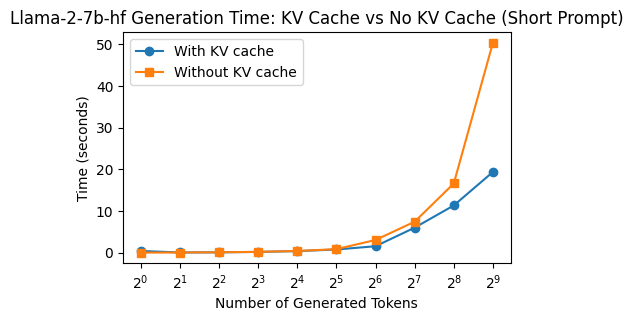

: 

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(range(len(token_counts)), times_exp4_with_kv, marker='o', label="With KV cache")
plt.plot(range(len(token_counts)), times_exp4_no_kv, marker='s', label="Without KV cache")
xticks = [f"$2^{{{i}}}$" for i in range(len(token_counts))]
plt.xticks(list(range(len(token_counts))), labels=xticks)
plt.xlabel("Number of Generated Tokens")
plt.ylabel("Time (seconds)")
plt.title("Llama-2-7b-hf Generation Time: KV Cache vs No KV Cache (Short Prompt)")
plt.legend()
plt.savefig("exp4_llama2_7b_short_prompt.pdf", bbox_inches="tight")
plt.show()